# Using Contextual Bradley-Terry for LMArena Style Control Leaderboard

This notebook processes the [`arena-human-preference-140k`](https://huggingface.co/datasets/lmarena-ai/arena-human-preference-140k) dataset to compute a leaderboard using a Contextual Bradley-Terry model, which controls for style elements in AI chat responses. This is the methodology used on the text leaderboard with style control. A full description is in our blog post: [Does style matter? Disentangling style and substance in Chatbot Arena](https://lmsys.org/blog/2024-08-28-style-control/).

We will:
1. Load the dataset.
2. Extract and normalize linguistic features (token count, bold usage, etc.).
3. Train the Contextual Bradley-Terry model using the `arena` package
4. Examine the style coefficients and plot the leaderboard and with confidence intervals.

In [1]:
import datasets
import pandas as pd

from arena.utils.data_utils import ContextualPairDataset
from arena.models.contextual_bradley_terry import ContextualBradleyTerry
from example_utils import add_style_feature_cols, plot_leaderboard

### Style Feature Preprocessing
We use 4 style features, the counts of tokens, lists, headers, and bold elements. We preprocess the features to be relative differences rather than absolute differences, and normalize over the dataset.

In [2]:
dataset = datasets.load_dataset(
    "lmarena-ai/arena-human-preference-140k",
    columns=["model_a", "model_b", "winner", "conv_metadata"],
    split="train",
)
df = dataset.to_pandas()

feature_cols = ["sum_assistant_tokens", "header_count", "bold_count", "list_count"]
df = add_style_feature_cols(df, feature_cols)

print(f"Processed {len(df)} rows.")
df.head()

Processed 135634 rows.


,model_a,model_b,winner,sum_assistant_tokens,header_count,bold_count,list_count
0,gemini-2.5-pro,claude-3-7-sonnet-20250219-thinking-32k,model_a,1.944768,1.208257,1.309957,1.757552
1,claude-3-5-haiku-20241022,claude-3-5-sonnet-20241022,tie,0.504124,1.554152,1.529277,1.086202
2,o3-mini,gemma-3n-e4b-it,both_bad,0.079100,-0.002373,-0.795110,-1.263523
3,claude-sonnet-4-20250514-thinking-32k,gemini-2.5-pro,model_a,-1.343709,-1.558897,-0.753905,-0.592173
4,claude-3-5-sonnet-20241022,mistral-medium-2505,model_b,-1.232194,-1.558897,-1.541210,-0.036783


### Modeling
To use the `arena` package, we perform the following steps:
1. Instantiate a `ContextualPairDataset` object from our pandas dataframe, this performs preprocessing and puts the data into a format optimized for model fitting.
2. Create an instance of the `ContextualBradleyTerry` model class with the desired settings.
3. "Train" the model by calling `compute_ratings_and_cis`, this computes the ratings and feature coefficients via maximum likelihood estimation, and the confidence intervals using a [sandwich estimator](https://www.stat.umn.edu/geyer/5601/notes/sand.pdf).

In [3]:
context_dataset = ContextualPairDataset.from_pandas(
    df,
    feature_cols=feature_cols,
)

model = ContextualBradleyTerry(
    n_competitors=len(context_dataset.competitors),
    n_features=len(feature_cols),
)

# compute ratings and 95% confidence intervals
results = model.compute_ratings_and_cis(context_dataset, significance_level=0.05)

In [4]:
# Create a dataframe for feature coefficients
coeff_df = pd.DataFrame({"Feature": feature_cols, "Coefficient": results["coeffs"]}).sort_values(
    by="Coefficient", ascending=False
)

print("Feature Coefficients (Impact on Win Rate):")
display(coeff_df)

Feature Coefficients (Impact on Win Rate):


,Feature,Coefficient
0,sum_assistant_tokens,0.038777
3,list_count,0.021697
2,bold_count,0.018733
1,header_count,0.016993


### Feature Interpretation
To understand the features let's imagine a scenario where two models gave responses, one with more tokens than the other, and that after feature normalization the feature value is 0.75.

Then we can model the increase in the log-odds of the first model being chosen due to the token difference as 0.75 * 0.03886 = 0.0291. Then converting to Elo rating scale we can do 0.0291 * (400 / log(10)) = 5.0631. So this token difference is equivalent to about a 5 point score difference.

### Leaderboard Visualization
We can plot the ratings and confidence intervals and visualize a leaderboard representing the style-controlled strengths. Note this leaderbaord is not not identical to the live leaderboard in July 2025 since this dataset is only a subset votes used for live leaderboard computation. However at that time, gemini-2.5-pro was in first and grok-4-0709, 03-2025-04-16, and chatgpt-4o-latest-20250326 were all in the top 5 as well.

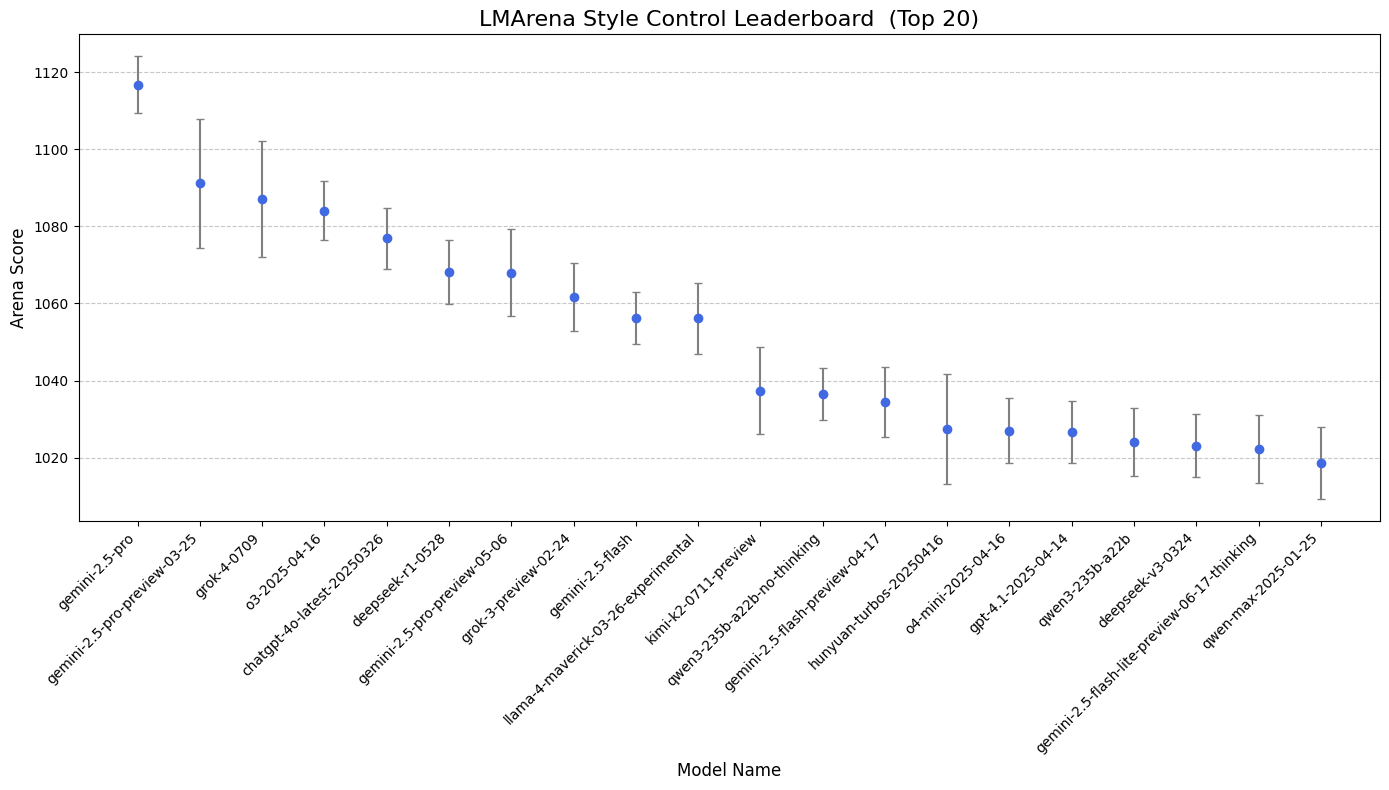

In [6]:
plot_leaderboard(results, competitors=context_dataset.competitors, top_n=20, title="LMArena Style Control Leaderboard ")